This tutorial will demonstrate the structure of the data file in an NWB (Neurodata Without Borders) file. In this particular example, we will be accessing information from an optotagging experiment, where the cells have light-gated ion channels that are activated by lasers. The data was taken using neuropixel opto (but details about all the devices used, as well as the experimental apparatus, are included in the NWB file).

We begin with package imports which we'll need:

In [1]:
import os
import glob
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget
import nwbinspector

from tqdm.auto import tqdm
import json

In order to do any analysis, of course, we'll also need the usual libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Accessing an NWB file

To manipulate the data in the file, we first need to load it into Python. We can do this using ```glob```, which will allow us to search the directory in which our data is located for particular strings. In this case, let's say we want to look for experiments involving a particular mouse.

In [3]:
mouse_id = '625098'

nwb_file = glob.glob(os.path.join('/data', '*' + mouse_id + '*', '*', '*.nwb.zarr'))[0]

print(nwb_file)

/data/ecephys_625098_2022-08-15_08-51-36_nwb_2023-05-16_16-28-23/ecephys_625098_2022-08-15_08-51-36_nwb/ecephys_625098_2022-08-15_08-51-36_experiment1_recording1.nwb.zarr


Above, we have used ```glob``` to look for all the files found in /data/ that include the mouse ID we're interested in and generates a Python list with each file's path as its entries. In this case, the data we have mounted only has one file pertaining to mouse 625098, so the list has only one object in it. However, if we had picked a different mouse ID, the list might have more than one entry, in which case we would need to select which file we wanted using a different index.

Now that we have the NWB file's path, we should read it into Python:

In [4]:
with NWBZarrIO(nwb_file, "r") as io:
    nwbfile_read = io.read()

At this point, we're ready to start working with the data. The first thing we might be interested in is just seeing the contents of the NWB file, which we can do by using the ```nwb2widget``` tool:

In [5]:
nwb2widget(nwbfile_read)

We can also access particular parts of the file. Of particular importance, for example, are the individual units (roughly corresponding to what we believe are individual neurons) in an experiment. We can access the units as a Pandas ```DataFrame``` object:

In [6]:
units = nwbfile_read.units[:]

Notice that the various tables contained in the file are simply attributes of the ```nwbfile_read``` object, which we access in the usual way ```nwbfile_read.*```.

In the units, we can examine what information we can gather from any particular unit of interest:

In [7]:
print(units.columns.values)

['spike_times' 'electrodes' 'waveform_mean' 'waveform_sd' 'unit_name'
 'num_spikes' 'amplitude' 'isi_violations_ratio' 'default_qc' 'snr'
 'd_prime' 'ks_unit_id' 'sliding_rp_violation' 'amplitude_cutoff'
 'repolarization_slope' 'drift_std' 'isolation_distance' 'peak_to_valley'
 'device_name' 'l_ratio' 'peak_trough_ratio' 'recovery_slope'
 'presence_ratio' 'drift_ptp' 'drift_mad' 'half_width' 'rp_violations'
 'firing_rate' 'rp_contamination']


In [21]:
print(units.iloc[0])

spike_times             [249.5327840854837, 249.55278609349838, 249.57...
electrodes              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
waveform_mean           [[-3.496347427368164, -0.8022295236587524, -1....
waveform_sd             [[36.19879150390625, 37.099369049072266, 33.44...
unit_name                            7d5990f0-f128-4e0a-ba4d-c858bc4e9f46
num_spikes                                                        52420.0
amplitude                                                      259.323608
isi_violations_ratio                                              0.00031
default_qc                                                           True
snr                                                              14.09992
d_prime                                                          4.629638
ks_unit_id                                                            0.0
sliding_rp_violation                                                0.005
amplitude_cutoff                      

We may also be interested in quality metrics for a given unit. We can access and plot them as follows:

In [46]:
print(units['isi_violations_ratio'])

id
0      0.000310
1      0.543146
2      0.644697
3      0.005970
4      0.070705
         ...   
447    0.000000
448    0.269065
449    0.058061
450    0.000000
451    5.715241
Name: isi_violations_ratio, Length: 452, dtype: float64


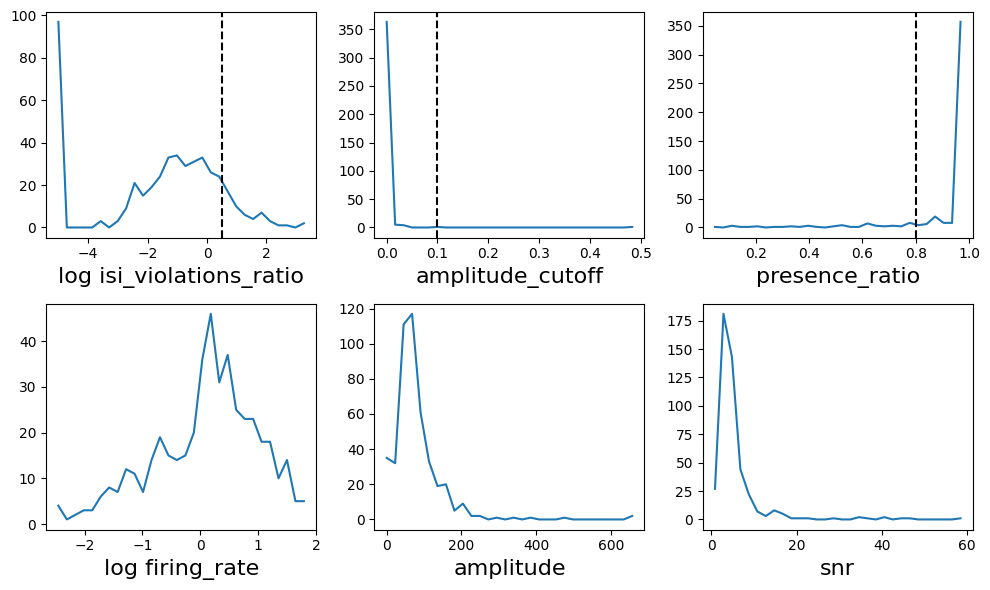

In [49]:
%matplotlib inline

def plot_metric(metric, threshold=None, use_log=False):  
    m = units[metric].dropna()
    if use_log:
        m = np.log10(m+1e-5) # add small offset to avoid log(0)
    h,v = np.histogram(m, bins=30)
    plt.plot(v[:-1],h)
    if use_log:
        plt.xlabel("log "+metric, fontsize=16)
    else:
        plt.xlabel(metric, fontsize=16)
    if threshold:
        plt.axvline(x=threshold, ls='--', color='k')
        
qc_metrics = ['isi_violations_ratio','amplitude_cutoff','presence_ratio','firing_rate','amplitude','snr']
thresholds = [0.5, 0.1, 0.8, None, None, None]
use_log = [True, False, False, True, False, False]
plt.figure(figsize=(10,6))
for i, metric in enumerate(qc_metrics):
    plt.subplot(2,3,i+1)
    plot_metric(metric, thresholds[i], use_log[i])
    plt.tight_layout()


And check how many of the units pass default quality control metrics:

In [50]:
units_passing_qc = units[units.default_qc=='True']
print(len(units_passing_qc))

234


We might also be interested in seeing details on the subject for this experiment:

In [11]:
print(nwbfile_read.subject)

subject pynwb.file.Subject at 0x139857478575968
Fields:
  age: P159D
  age__reference: birth
  date_of_birth: 2022-03-09 00:00:00-08:00
  genotype: Slc17a6-IRES-Cre/wt
  sex: F
  species: Mus musculus
  subject_id: 625098



Or information on the trials done and what information we can look at in each trial:

In [17]:
trials = nwbfile_read.trials[:]
print(trials.columns.values)

['start_time' 'stop_time' 'site' 'power' 'param_group' 'duration'
 'rise_time' 'num_pulses' 'wavelength' 'type' 'inter_pulse_interval'
 'stimulus_template_name']


In [18]:
print(trials.stimulus_template_name.unique())

['internal_red-short_pulse-0.06mW' 'internal_red-train-0.01mW'
 'external_red-short_pulse-10.0mW' 'external_red-short_pulse-5.0mW'
 'internal_red-long_pulse-0.06mW' 'internal_red-train-0.06mW'
 'external_red-long_pulse-1.0mW' 'external_red-train-1.0mW'
 'internal_red-short_pulse-0.01mW' 'external_red-train-3.0mW'
 'internal_red-long_pulse-0.01mW' 'external_red-long_pulse-2.0mW'
 'external_red-short_pulse-4.0mW' 'external_red-train-4.0mW'
 'external_red-train-5.0mW' 'external_red-train-10.0mW'
 'external_red-short_pulse-3.0mW' 'external_red-long_pulse-3.0mW'
 'external_red-long_pulse-4.0mW' 'external_red-short_pulse-1.0mW'
 'external_red-train-2.0mW' 'external_red-long_pulse-10.0mW'
 'external_red-long_pulse-5.0mW' 'external_red-short_pulse-2.0mW']


In [24]:
print(len(trials))

5100


In [25]:
print(trials.iloc[1582])

start_time                                   1211.763679
stop_time                                    1212.593679
site                                                   0
power                                                4.0
param_group                                  short_pulse
duration                                            0.01
rise_time                                          0.001
num_pulses                                             1
wavelength                                           638
type                                        external_red
inter_pulse_interval                                 0.0
stimulus_template_name    external_red-short_pulse-4.0mW
Name: 1582, dtype: object


We might be interested in looking for issues with the data or ways to improve efficiency when grabbing data (for example, if our time steps are constant, it might be better to simply specify a time range and a sampling rate). One way to look for this is by using ```NWBInspector``` to check for compliance with best practices. We can look grab any messages that ```NWBInspector``` has using the ```inspect_nwbfile_object``` command. 

In [26]:
from nwbinspector import inspect_nwbfile_object

messages = list(inspect_nwbfile_object(nwbfile_read))

In [30]:
print(len(messages))

81


This has given us 81 messages, but they're not all necessarily critical messages. Let's take a look at the information in a particular message:

In [34]:
print(messages[0])

InspectorMessage(
    message="Description ('No description.') is a placeholder.",
    importance=<Importance.BEST_PRACTICE_SUGGESTION: 0>,
    severity=<Severity.LOW: 1>,
    check_function_name='check_description',
    object_type='VectorData',
    object_name='rp_contamination',
    location=None,
    file_path=None
)


As we can see, this isn't very readable. We can improve readability using a built-in tool in ```nwbinspector```, ```format_messages```:

In [35]:
from nwbinspector.inspector_tools import format_messages

print("\n".join(format_messages(messages, levels=["importance"])))

**************************************************
NWBInspector Report Summary

Timestamp: 2024-06-11 19:10:43.080224+00:00
Platform: Linux-4.14.343-260.564.amzn2.x86_64-x86_64-with-glibc2.10
NWBInspector version: 0.4.28

Found 81 issues over 1 files:
      25 - BEST_PRACTICE_VIOLATION
      56 - BEST_PRACTICE_SUGGESTION
**************************************************


.0  Importance.BEST_PRACTICE_VIOLATION: None - check_time_interval_time_columns - 'TimeIntervals' object with name 'trials'
      Message: ['rise_time'] are time columns but the values are not in ascending order. All times should be in seconds with respect to the session start time.

.1  Importance.BEST_PRACTICE_VIOLATION: None - check_regular_timestamps - 'TimeSeries' object with name 'internal_red-train-0.06mW'
      Message: TimeSeries appears to have a constant sampling rate. Consider specifying starting_time=-0.01 and rate=3.333333333333313e-05 instead of timestamps.

.2  Importance.BEST_PRACTICE_VIOLATION: None